Implementation of the simplified Ising model, using the networkx and graphviz packages. 

Cell structure: 
1. Class implementations for simplified Ising model in Square, Triangular, and Hexagonal geometries.
2. Simulate and visualize initial and final states for all three geometries.
3. Compare magnetization over temperature and coupling strength - find phase transition, for all three geometries.
4. Comparison of initial state, final state, and energy over time at four temperatures, for all three geometries. 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
class TriangularIsingModel:
    '''Ising Model on a triangular lattice, generated with the networkx package'''
    
    # def __init__(self, size, J=1.0):
    def __init__(self, size: int, J: float = 1.0):
        
        self.size = size
        self.J = J
        self.state = None
        self.G = nx.generators.lattice.triangular_lattice_graph(size, size) # Create triangular lattice graph
        
        # Convert node labels to (i,j) pairs, and make a list of nodes
        self.G = nx.convert_node_labels_to_integers(self.G, ordering="sorted") 
        self.nodes = list(self.G.nodes())

    def initialize_random(self, spin_up_fraction):
        '''Initalize each node as a 1 or -1, with given probability for spin_up_fraction. Store spin in a dictionary.'''
        self.state = {
            node: np.random.choice([-1, 1], p=[1-spin_up_fraction, spin_up_fraction])
            for node in self.nodes
        }
        return self.state

    def energy(self, state=None):
        '''Calcuates the energy of the state based on neighbors'''
        if state is None:
            state = self.state

        E = 0.0
        for u, v in self.G.edges():
            E -= self.J * state[u] * state[v]
        return E

    def magnetization(self, state=None):
        '''Evaluated mangetization (average spin) for lattice.'''
        if state is None:
            state = self.state
        return np.mean(list(state.values()))

    def simulate(self, temperature, n_steps):
        """Metropolis simulation on graph-based Ising model."""
        states = [self.state.copy()]
        energies = [self.energy()]
        magnetizations = [self.magnetization()]

        for step in range(n_steps):
            # pick random node
            node = np.random.choice(self.nodes)

            # propose flip
            new_state = self.state.copy()
            new_state[node] *= -1  

            # energies
            E_old = self.energy()
            E_new = self.energy(new_state)
            dE = E_new - E_old

            # Metropolis acceptance
            if dE < 0 or np.random.rand() < np.exp(-dE / temperature):
                self.state = new_state

            # record every 100
            if (step+1) % 100 == 0:
                states.append(self.state.copy())
                energies.append(self.energy())
                magnetizations.append(self.magnetization())

        return states, energies, magnetizations

class HexagonalIsingModel(TriangularIsingModel):
    '''Ising Model on a hegaxonal lattice.
    Should be able to use the same machinery as the triangular lattice.'''
    def __init__(self, size, J=1.0):
        super().__init__(size, J)
        self.G = nx.generators.lattice.hexagonal_lattice_graph(size, size) # Create hexagonal lattice graph

        # Convert node labels to (i,j) pairs, and make a list of nodes
        self.G = nx.convert_node_labels_to_integers(self.G, ordering="sorted")
        self.nodes = list(self.G.nodes())

class SquareIsingModel(TriangularIsingModel):
    '''Ising Model on a hegaxonal lattice.
    Should be able to use the same machinery as the triangular lattice.'''
    def __init__(self, size, J=1.0):
        super().__init__(size, J)
        self.G = nx.generators.lattice.grid_2d_graph(size, size) # Create hexagonal lattice graph

        # Convert node labels to (i,j) pairs, and make a list of nodes
        self.G = nx.convert_node_labels_to_integers(self.G, ordering="sorted")
        self.nodes = list(self.G.nodes())

~ TRIANGULAR LATTICE ~
Lattice size: 3 x 3
Coupling strength J: 1.0
Temperature T: 1.0


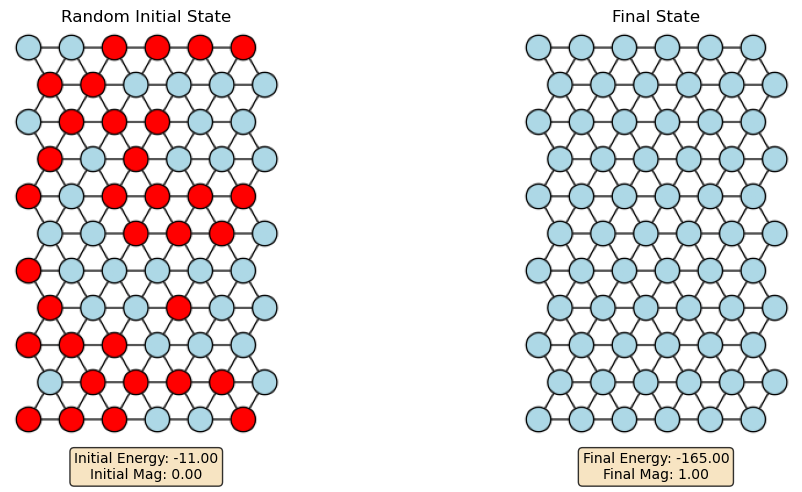

~ HEXAGONAL LATTICE ~
Lattice size: 3 x 3
Coupling strength J: 1.0
Temperature T: 1.0


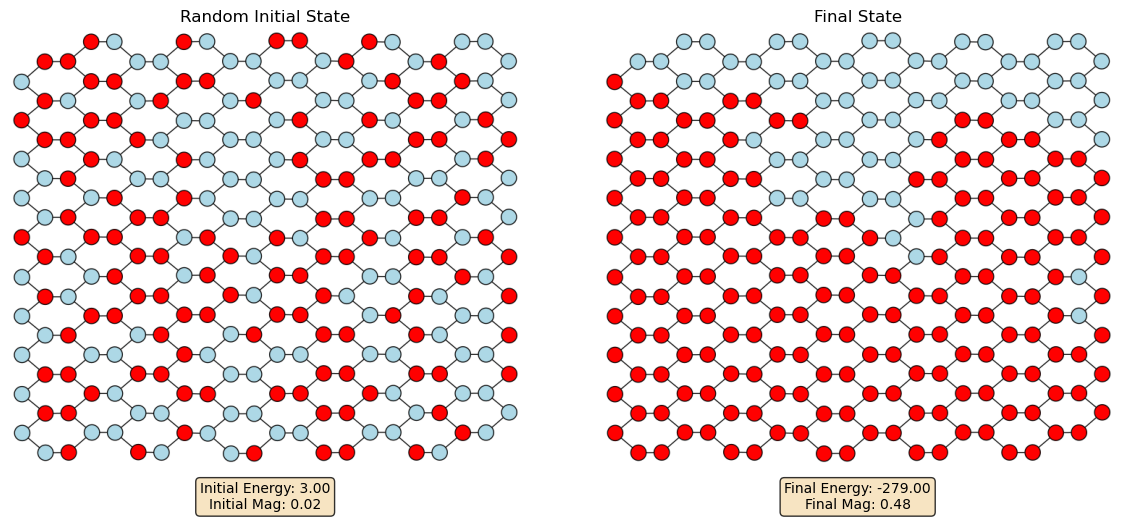

~ SQUARE LATTICE ~
Lattice size: 3 x 3
Coupling strength J: 1.0
Temperature T: 1.0


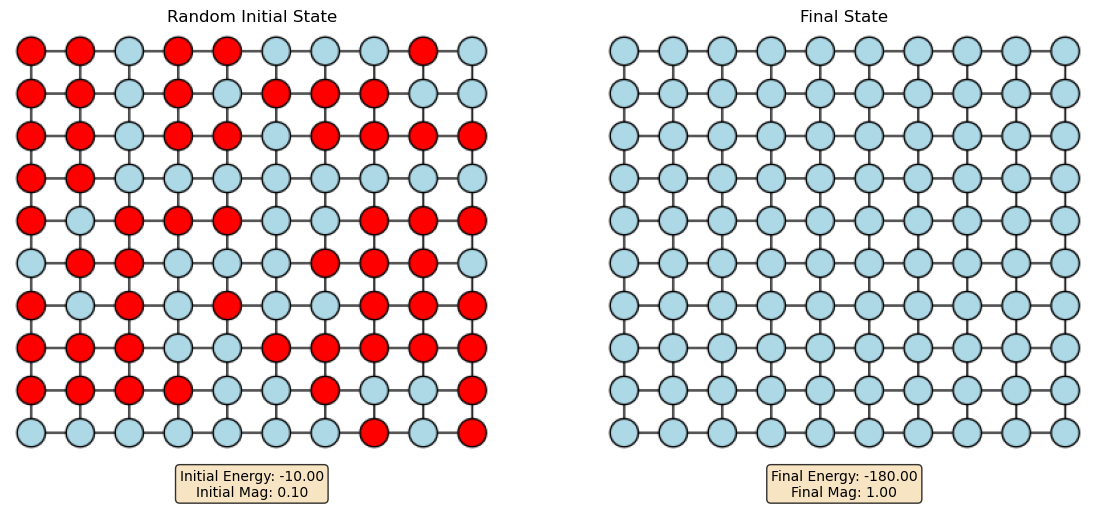

In [6]:
###-----Plot initial and final states for all 3 geometries
import math
from graphviz import Graph, dot
from IPython.display import Image, display
import io

# Initialize and run simulation for triangular lattice

# Visualize initial and final states

def lattice_positions_from_size(model_type, size):
    """
    Build a triangular lattice with integer node labels (using sorted' ordering) and return a 
    dict mapping integer node -> (x,y). if statement selects for geometry.
    """
    # build a fresh triangular lattice and convert labels while keeping original coords
    Gtmp = None
    if model_type == TriangularIsingModel:
        Gtmp = nx.generators.lattice.triangular_lattice_graph(size, size)
    elif model_type == HexagonalIsingModel:
        Gtmp = nx.generators.lattice.hexagonal_lattice_graph(size, size)
    elif model_type == SquareIsingModel:
        Gtmp = nx.generators.lattice.grid_2d_graph(size, size)
    
    # convert to integers but keep original coords in node attribute 'coord'
    G_int = nx.convert_node_labels_to_integers(Gtmp, ordering="sorted", label_attribute="coord")
    

    color = nx.algorithms.bipartite.color(G_int) if model_type == HexagonalIsingModel else None # {node: 0 or 1}

    pos = {}
    dy = math.sqrt(3) / 2.0
    dx = 1.0
    for n, data in G_int.nodes(data=True):
        coord = data.get("coord")
        # original coords are likely (i, j) tuples
        if isinstance(coord, tuple) and len(coord) >= 2:
            i, j = coord[0], coord[1] # offset every other row to make triangular packing
            x = (i + 0.5 * (j % 2)) if model_type == TriangularIsingModel else ((2*dx*i + dx * color[n]) if model_type == HexagonalIsingModel else i)   
            y = j * dy
            pos[n] = (x, y)
        else:
            # fallback: use spring layout (should not happen for triangular_lattice_graph)
            pos[n] = (0.0, 0.0)
    return pos

def visualize_state_graphviz(model, state, filename, pos=None, node_size=0.22):
    """
    Render the graph state using graphviz.
    - model: instance of TriangularIsingModel
    - state: dict mapping node->spin (+1 or -1)
    - filename: path prefix (Graphviz will create filename+'.png')
    - pos: optional dict node -> (x,y). If None, computed from model.size
    - node_size: approximate node diameter in inches for Graphviz fixedsize
    """
    
    if pos is None:
        pos = lattice_positions_from_size(type(model), model.size)

    # Create an undirected graph in graphviz using neato (pos attributes respected)
    g = Graph(engine="neato", format="png")
    # Graph attributes to make positions fixed
    g.attr(overlap="false")
    g.attr(splines="true")  # nice straight/curved edges depending on geometry
    g.attr(nodesep="0.08")

    # Add nodes with fill colors according to spins
    for n in model.nodes:
        spin = state.get(n, 1)
        # choose color scheme (you can change names)
        if spin == 1:
            fill = "red"
        else:
            fill = "lightblue"
        x, y = pos[n]
        # Graphviz pos expects "x,y!" (the '!' tells neato to use it as fixed position)
        pos_str = f"{x},{y}!"
        # set fixedsize and width so nodes are visually small and consistent
        g.node(str(n),
               label="",
               style="filled",
               fillcolor=fill,
               shape="circle",
               pos=pos_str,
               width=str(node_size),
               fixedsize="true")
    # Add edges
    for u, v in model.G.edges():
        g.edge(str(u), str(v), arrowhead="none")

    png_bytes = g.pipe(format="png")
    return png_bytes



def viz_initial_and_final_network(model_type, size=5, J=1.0, temperature=1.0, n_steps=10000):
    ''' Calculates and displays initial and final state in lattice graph for model_type, of given size, J, and temp. 
    Defaults to size =5, J=1.0, temp = 1.0, and n_steps=10000'''

    model = model_type(size=size, J=J)

    # store initial random state and visualize it
    initial_state = model.initialize_random(spin_up_fraction=0.5)
    pos = lattice_positions_from_size(model_type, model.size)
    initial_png = visualize_state_graphviz(model, initial_state, filename="triangular_initial", pos=pos)

    # Run simulation
    states, energies, mags = model.simulate(temperature, n_steps)

    # Final state (after simulation)
    final_state = model.state.copy()
    final_png = visualize_state_graphviz(model, final_state, filename="triangular_final", pos=pos)


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    #Initial state
    ax1.imshow(plt.imread(io.BytesIO(initial_png)))
    ax1.set_title('Random Initial State', fontsize=12)
    ax1.axis('off')
    initial_text = f"Initial Energy: {energies[0]:.2f}\nInitial Mag: {mags[0]:.2f}"
    ax1.text(0.5, -0.1, initial_text, transform=ax1.transAxes, 
            ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    #Final state
    ax2.imshow(plt.imread(io.BytesIO(final_png)))
    ax2.set_title('Final State', fontsize=12)
    ax2.axis('off')
    final_mag = model.magnetization(states[-1])
    final_text = f"Final Energy: {energies[-1]:.2f}\nFinal Mag: {abs(final_mag):.2f}"
    ax2.text(0.5, -0.1, final_text, transform=ax2.transAxes, 
            ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()


# Create triangular lattice model
triangular_model = TriangularIsingModel(size=3, J=1.0)
hexagonal_model = HexagonalIsingModel(size=3, J=1.0)
square_model = SquareIsingModel(size=3, J=1.0)

T = 1.0

#plot initial and final for all
print("~ TRIANGULAR LATTICE ~")
print(f"Lattice size: {triangular_model.size} x {triangular_model.size}")
print(f"Coupling strength J: {triangular_model.J}")
print(f"Temperature T: {T}")
viz_initial_and_final_network(TriangularIsingModel, size=10, temperature=T)

print("~ HEXAGONAL LATTICE ~")
print(f"Lattice size: {hexagonal_model.size} x {hexagonal_model.size}")
print(f"Coupling strength J: {hexagonal_model.J}")
print(f"Temperature T: {T}")
viz_initial_and_final_network(HexagonalIsingModel, size=10, temperature=T)

print("~ SQUARE LATTICE ~")
print(f"Lattice size: {square_model.size} x {square_model.size}")
print(f"Coupling strength J: {square_model.J}")
print(f"Temperature T: {T}")
viz_initial_and_final_network(SquareIsingModel, size=10, temperature=T)


Square:


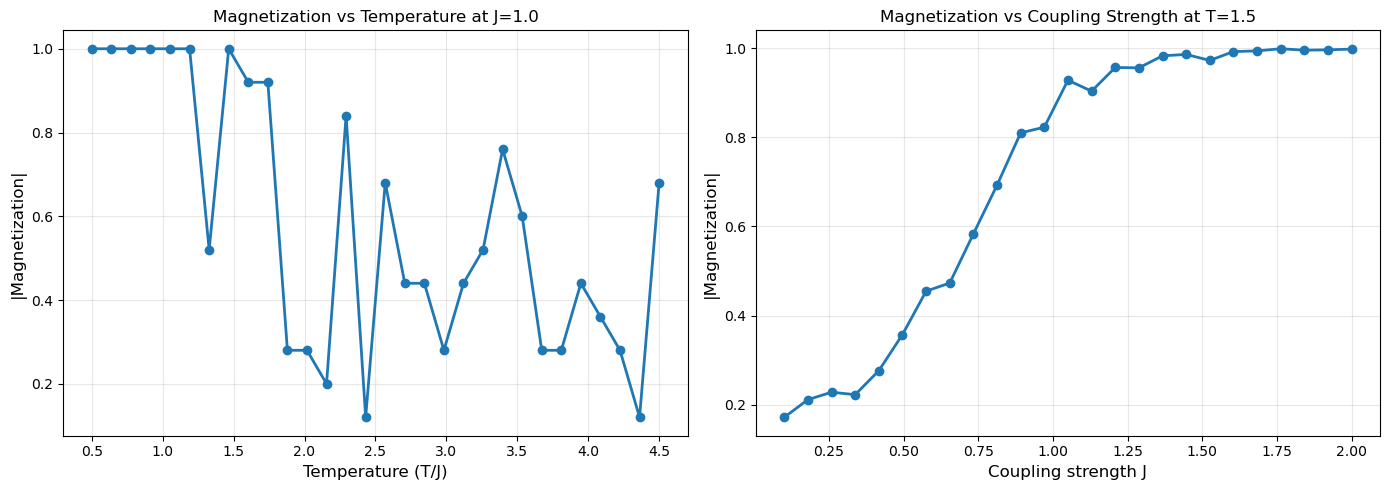

Triangle:


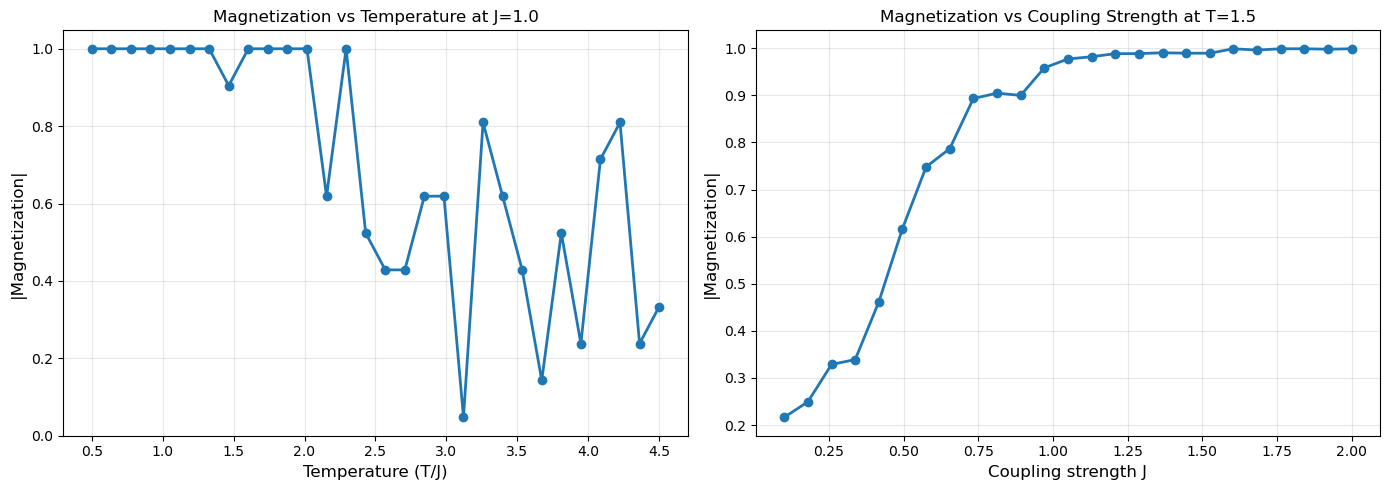

Hex:


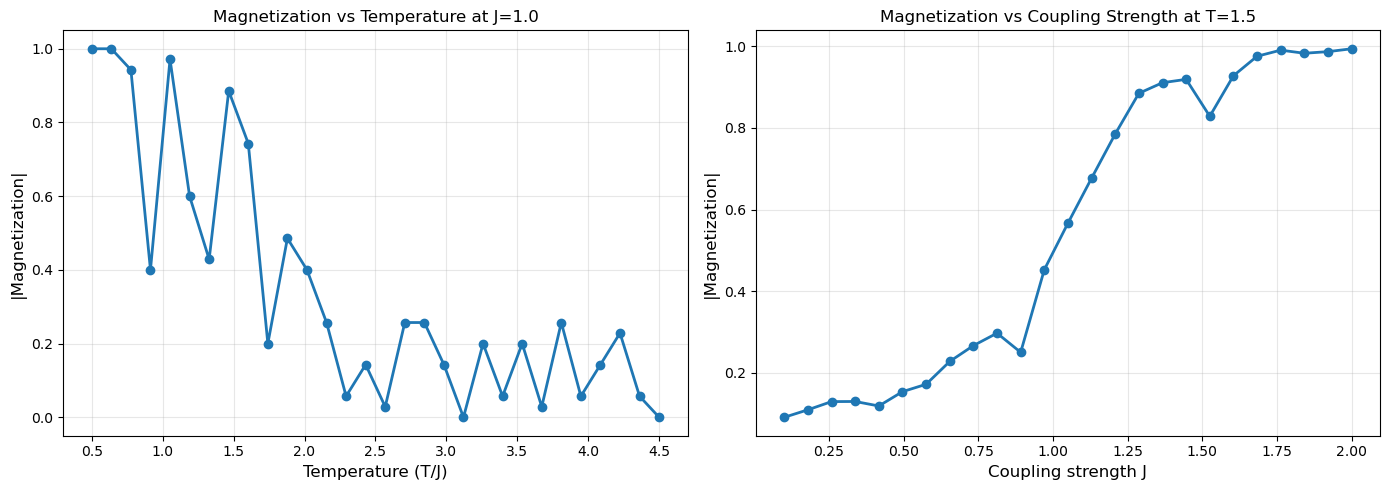

In [12]:
#coupling and phase transition code here
#clean up nd configure for networkx specific application

##SCAN OVER TEMPERATURE, COUPLING STRENGTH (for all three geom)
#Beware, this takes a long time to run

#See how the overall magnetization is affected by the background temperature by scanning over temperatures
def find_phase_transition(model_type,size=10, temps=None, n_steps=10000, n_equilibration=10000):
    '''Simulate ising with several background temperatures'''
    if temps is None:
        temps = np.linspace(0.5, 4.5, 30)

    magnetizations = []
    for T in temps:
        # print(f"T = {T:.2f}")
        model = model_type(size)
        model.initialize_random(spin_up_fraction=0.7)

        # Run simulation
        states, energies, mags = model.simulate(T, n_steps)

        eq_idx = n_equilibration // 100
        mags_eq = np.array(mags[eq_idx:])

        mean_mag = np.mean(np.abs(mags_eq))
        magnetizations.append(mean_mag)

    return temps, magnetizations

#See how overall magnetization is affeccted by the coupling strength
def find_coupling_transition(model_type, size=20, Js=None, temperature=T, n_steps=20000, n_equilibration=10000):
    """Scan magnetization vs coupling strength J at fixed temperature."""
    if Js is None:
        Js = np.linspace(0.1, 1.5, 20)
    magnetizations = []
    for Jval in Js:
        model = model_type(size, Jval)
        model.initialize_random(spin_up_fraction=0.7)
        states, energies, mags = model.simulate(temperature=temperature, n_steps=n_steps)
        eq_idx = max(0, n_equilibration // 100)  # mags recorded every 100 steps
        mags_eq = np.array(mags[eq_idx:]) if len(mags) > eq_idx else np.array(mags)
        magnetizations.append(np.mean(np.abs(mags_eq)))
    return Js, magnetizations


#Run and display temperature and coupling strength relations
def plot_temp_and_J_scans(model_type, size, J=1.0, n_steps=20000):
    model = model_type(size, J)

    # Run the scans, Change model type to plot different models
    temps, mags = find_phase_transition(model_type, model.size, n_steps=10000, n_equilibration=10000)
    Js, mags_vs_J = find_coupling_transition(model_type, model.size, Js=np.linspace(0.1, 2.0, 25), temperature=1.5, n_steps=20000, n_equilibration=10000)

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Magnetization vs Temperature
    ax1.plot(temps, mags, 'o-', markersize=6, linewidth=2)
    ax1.set_xlabel('Temperature (T/J)', fontsize=12)
    ax1.set_ylabel('|Magnetization|', fontsize=12)
    ax1.set_title(f'Magnetization vs Temperature at J={J}', fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Magnetization vs Coupling Strength
    ax2.plot(Js, mags_vs_J, 'o-', linewidth=2)
    ax2.set_xlabel('Coupling strength J', fontsize=12)
    ax2.set_ylabel('|Magnetization|', fontsize=12)
    ax2.set_title(f'Magnetization vs Coupling Strength at T={1.5}', fontsize=12)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("Square:")
plot_temp_and_J_scans(SquareIsingModel, 5)
print("Triangle:")
plot_temp_and_J_scans(TriangularIsingModel, 5)
print("Hex:")
plot_temp_and_J_scans(HexagonalIsingModel, 5)


Simulating at T = 0.5
  Final magnetization: 1.000

Simulating at T = 1.5
  Final magnetization: 0.840

Simulating at T = 2.5
  Final magnetization: 0.680

Simulating at T = 4.0
  Final magnetization: 0.040


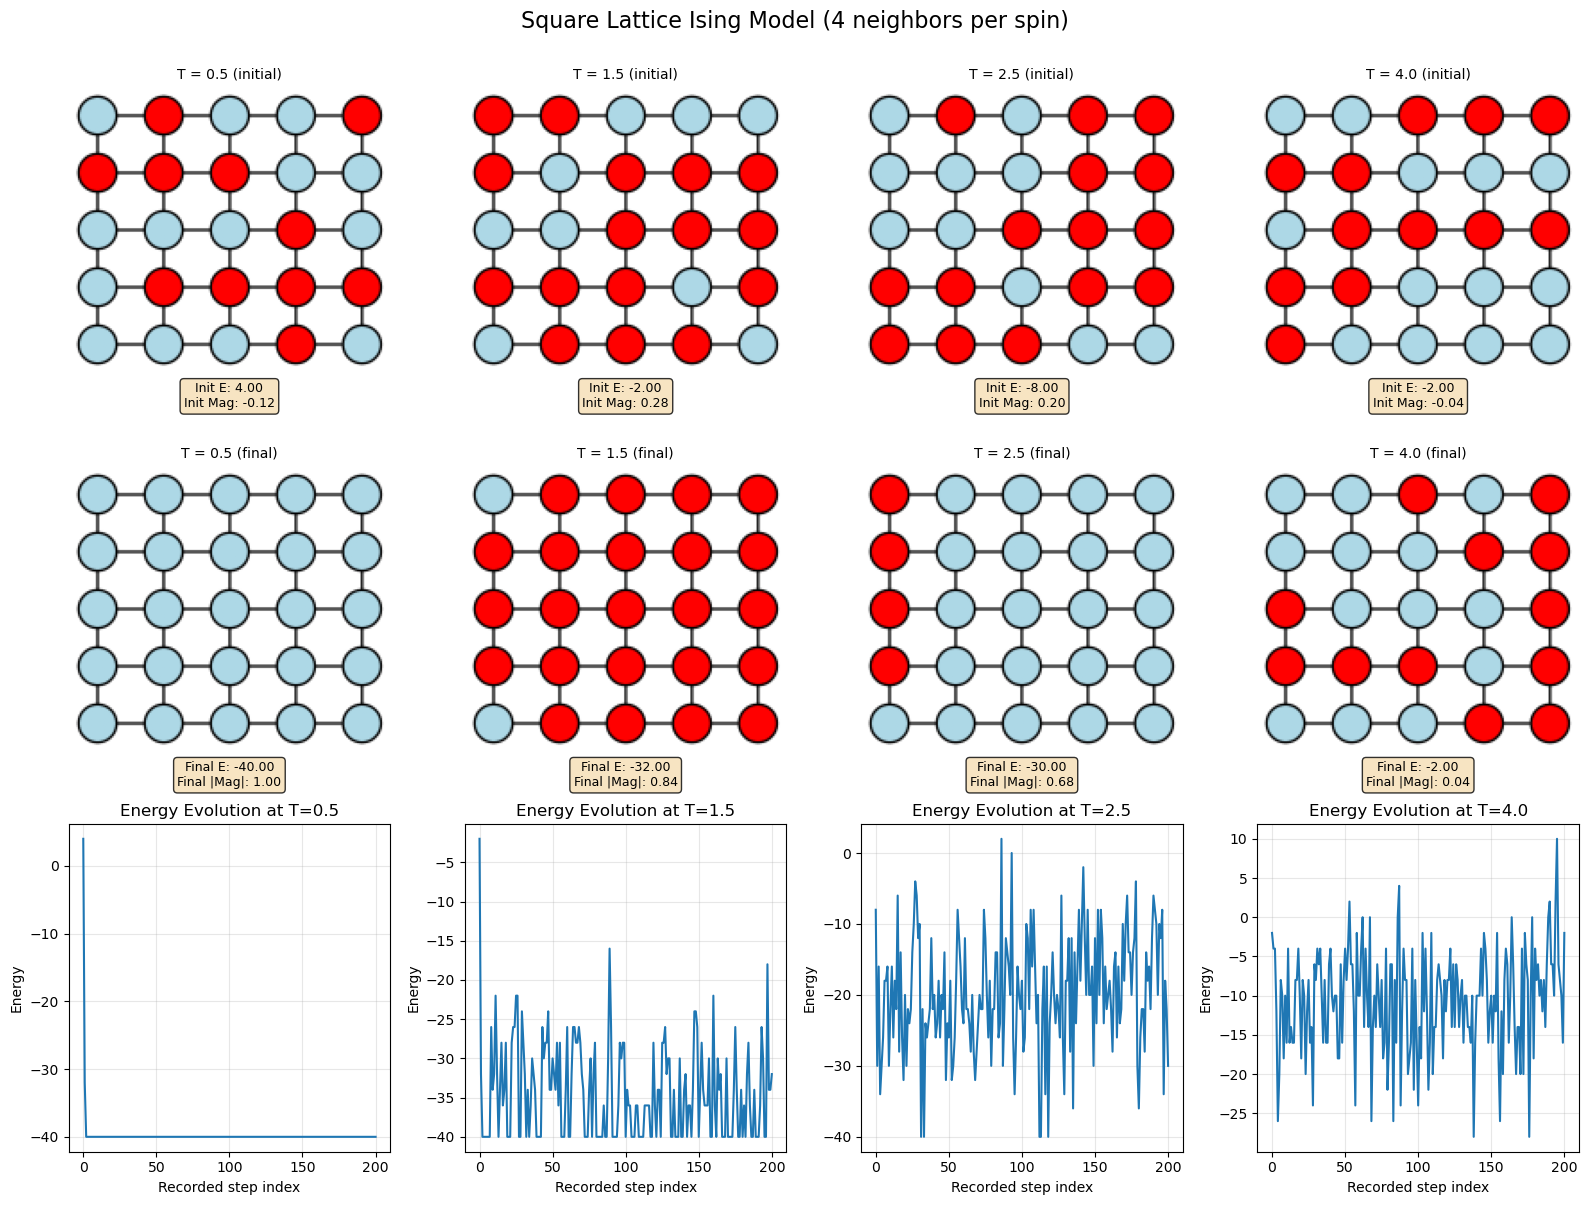


Simulating at T = 0.5
  Final magnetization: 1.000

Simulating at T = 1.5
  Final magnetization: 1.000

Simulating at T = 2.5
  Final magnetization: 0.905

Simulating at T = 4.0
  Final magnetization: 0.619


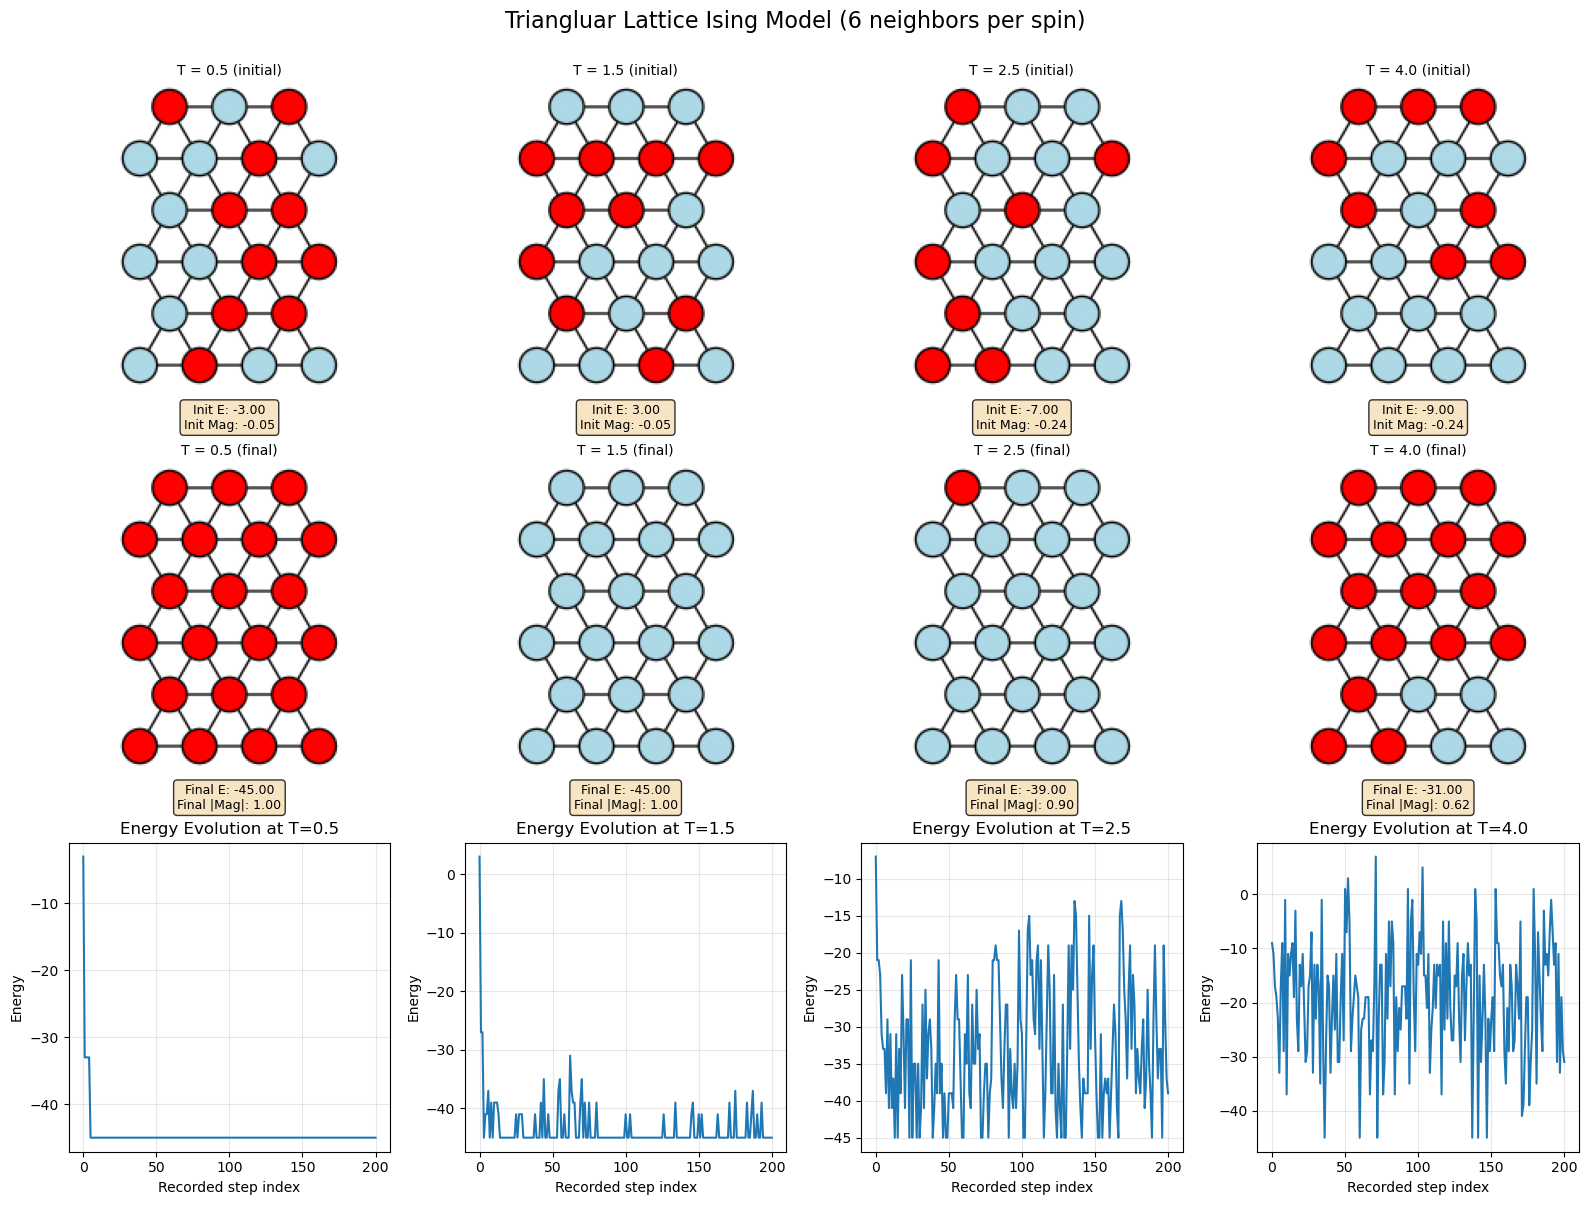


Simulating at T = 0.5
  Final magnetization: 1.000

Simulating at T = 1.5
  Final magnetization: 0.400

Simulating at T = 2.5
  Final magnetization: 0.457

Simulating at T = 4.0
  Final magnetization: 0.057


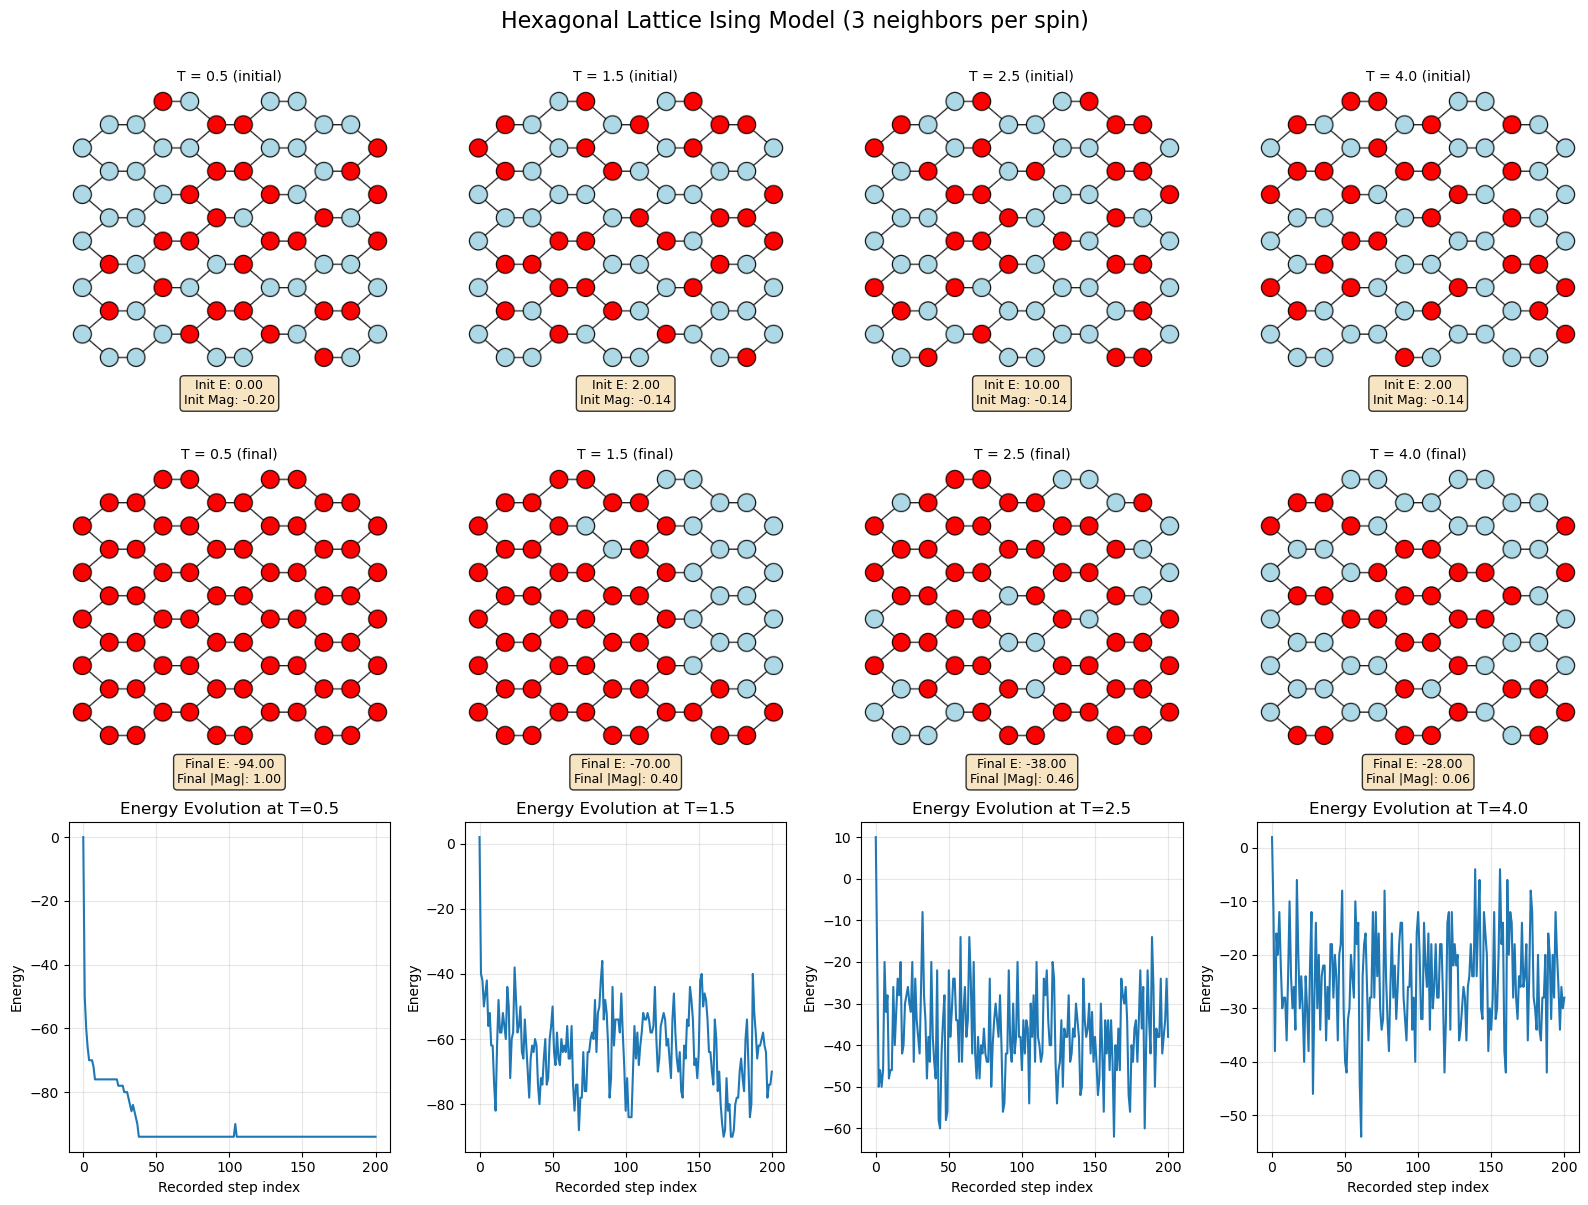

In [11]:
#mega grid code here
#needs to be configured for networkx fellows

##VISULAIZE INTIAL AND FINAL STATES FOR MULTIPLE TEMPERATURES 
def init_and_final_over_T_network(model_type, size=5, J=1.0):

    model = model_type(size=size, J=J)

    if type(model) == SquareIsingModel:
        name = "Square"
        neighbors = 4
    elif type(model) == TriangularIsingModel:
        name = "Triangluar"
        neighbors = 6
    else:
        name = "Hexagonal"
        neighbors = 3

    temperatures = [0.5, 1.5, 2.5, 4.0]

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle(f'{name} Lattice Ising Model ({neighbors} neighbors per spin)', fontsize=16, y=1.00)

    for idx, T in enumerate(temperatures):
        print(f"\nSimulating at T = {T}")

        # store initial random state and visualize it
        initial_state = model.initialize_random(spin_up_fraction=0.5)
        pos = lattice_positions_from_size(model_type, model.size)
        initial_png = visualize_state_graphviz(model, initial_state, filename="1", pos=pos)

        # Run simulation
        states, energies, mags = model.simulate(T, n_steps=20000)

        # Final state (after simulation)
        final_state = model.state.copy()
        final_png = visualize_state_graphviz(model, final_state, filename="2", pos=pos)

        # Row 0: initial image
        ax_init = axes[0, idx]
        ax_init.imshow(plt.imread(io.BytesIO(initial_png)))
        ax_init.set_title(f"T = {T} (initial)", fontsize=10)
        ax_init.axis('off')
        init_text = f"Init E: {energies[0]:.2f}\nInit Mag: {mags[0]:.2f}"
        ax_init.text(0.5, -0.12, init_text, transform=ax_init.transAxes,
                     ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        # Row 1: final image
        ax_final = axes[1, idx]
        ax_final.imshow(plt.imread(io.BytesIO(final_png)))
        ax_final.set_title(f"T = {T} (final)", fontsize=10)
        ax_final.axis('off')
        final_mag = model.magnetization(states[-1])
        final_text = f"Final E: {energies[-1]:.2f}\nFinal |Mag|: {abs(final_mag):.2f}"
        ax_final.text(0.5, -0.12, final_text, transform=ax_final.transAxes,
                      ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        # Row 2: energy evolution
        ax_energy = axes[2, idx]
        ax_energy.plot(energies)
        ax_energy.set_xlabel('Recorded step index')
        ax_energy.set_ylabel('Energy')
        ax_energy.set_title(f'Energy Evolution at T={T}')
        ax_energy.grid(alpha=0.3)

        final_mag = model.magnetization(states[-1])
        print(f"  Final magnetization: {abs(final_mag):.3f}")

    plt.tight_layout()
    plt.show()


init_and_final_over_T_network(SquareIsingModel, size=5, J=1.0)

Triangular = TriangularIsingModel(size=5, J =1.0)
init_and_final_over_T_network(TriangularIsingModel, size=5, J=1.0)

Hexagonal = HexagonalIsingModel(size=5, J=1.0)
init_and_final_over_T_network(HexagonalIsingModel, size=5, J=1.0)